<img src="img/mvp_art.png" width=200 height=200 />

# Predicting the NBA's Most Valuable Player
### CMSC 320 Final Project
#### John Newhagen, Rahul Reddy, & Austin Smith
---

### Project Description:
In this project, we aim to...

Sources: https://www.basketball-reference.com/, https://basketball.realgm.com/
___

### Importing Packages and Modifying Settings
Before we can begin collecting our data, we must import the packages that will be used throughout the project.
* First, os will allow us to interact with our local files
* Secondly, pandas and numpy which will allow us to properly clean and display our data.
* Then, matplotlib and seaborn will be used for plotting our data.
* Finally, SciKit Learn and SciPy will be used to create a model for MVP Voting Share.

In [1]:
# Enter into terminal to update website: jupyter nbconvert --to html index.ipynb
import os
# Web-scraping and Data-handling packages
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import unidecode as uni
# Plotting packages
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
register_matplotlib_converters()
import seaborn as sns
sns.set(style="darkgrid")
# Regression Modeling packages
from sklearn import linear_model, svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor as rcr
from sklearn.metrics import classification_report
from scipy import stats

## Finding MVP Candidates
---

The first step in our process is determining who has won the NBA's Most Valuable player award and who the candidates for MVP have been since the 2000-01 NBA season. This cutoff was used as the NBA and basketball have changed over the years so constraining our data to the most recent 18 seasons should allow us to account for some of the changes while still collecting enough data to create a realistic model of MVP Voting Share.\
First we create a couple functions that will allow us to modify the table we will be scraping from basketball-reference.

In [2]:
# This function takes a pandas dataframe and renames all unnamed levels to remove them from the table
# Returns the rennamed dataframe
def rename_unnamed(df):
    for i, columns in enumerate(df.columns.levels):
        columns_new = columns.tolist()
        for j, row in enumerate(columns_new):
            if 'Unnamed: ' in row:
                columns_new[j] = ''
        df = df.rename(columns=dict(zip(columns.tolist(), columns_new)), level=i)
    return df
# This fuction takes a pandas dataframe and collapses the columns of a MultiIndexed pandas dataframe
# Returns the collapsed dataframe
def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: "".join(x))
    return df

Now that we have those, we can proceed by creating a dataframe containing the top 5 MVP candidates from 2001 to 2019 and their Rank and VotingShare.\
First, we use pandas to obtain the table containing our data, then we modify the table using the functions declared above, and finally we select the columns we want and add them to the votes dictionary with the key value of the season.

In [3]:
votes_df = pd.DataFrame()
for year in range(2001,2020):
    data = pd.read_html('https://www.basketball-reference.com/awards/awards_' + str(year) + '.html')[0]
    data = collapse_columns(rename_unnamed(data))
    data['Year'] = year
    votes_df = votes_df.append(data.loc[:4, ['Year', 'Rank', 'Player', 'Tm', 'VotingShare']])
votes_df['Rank'] = votes_df['Rank'].astype(int)
votes_df.head(10)

,Year,Rank,Player,Tm,VotingShare
0,2001,1,Allen Iverson,PHI,0.904
1,2001,2,Tim Duncan,SAS,0.569
2,2001,3,Shaquille O'Neal,LAL,0.466
3,2001,4,Chris Webber,SAC,0.420
4,2001,5,Kevin Garnett,MIN,0.122
0,2002,1,Tim Duncan,SAS,0.757
1,2002,2,Jason Kidd,NJN,0.712
2,2002,3,Shaquille O'Neal,LAL,0.552
3,2002,4,Tracy McGrady,ORL,0.310
4,2002,5,Kobe Bryant,LAL,0.078


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x360 with 0 Axes>

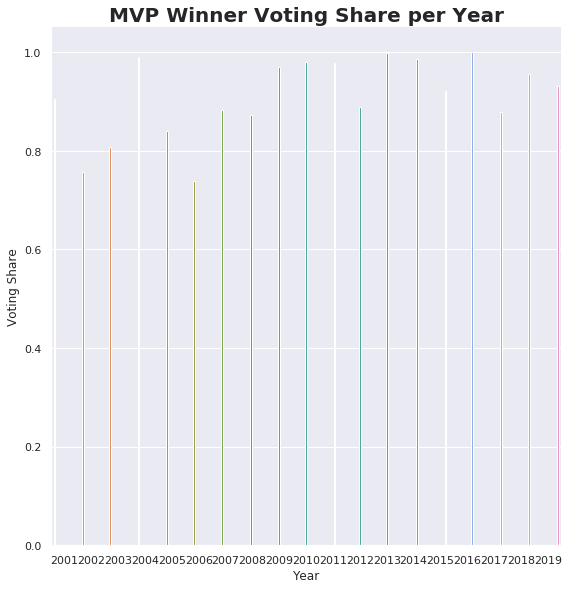

In [4]:
plt.figure(figsize=(10,5))
p = sns.factorplot(x='Year',y='VotingShare', hue='Player', data=votes_df[votes_df['Rank'] == 1], 
                   size=8, kind="bar", legend=False)
plt.title('MVP Winner Voting Share per Year', fontweight="bold", fontsize=20)
plt.xlabel('Year')
plt.ylabel('Voting Share')
plt.show()

## MVP Candidate Database Builder
---

Now that we have a list of MVP candidates and their voting shares, we want to collect some statistics for all of our MVP candidates.\
We will be collecting data in terms of three separate metrics: 
* Per-Game statistics
* Team statistics
* Contribution statistics (Per-Game/Team)

In [5]:
def normalize(name, j):
    return str.lower(name.split()[1])[:1] + '/' + \
                            uni.unidecode(str.lower(name.split()[1]).replace("'", "").replace('-',''))[:5] + \
                                str.lower(name.split()[0]).replace("'", "")[:2] + '0' + str(j)

def tabulate(row, name, year, i):
    row['Name'] = name
    if name in list(votes_df[votes_df['Year'] == year]['Player']):
        row['VotingShare'] = votes_df[votes_df['Year'] == year]['VotingShare'][i]
        row['Ranking'] = votes_df[votes_df['Year'] == year]['Rank'][i]
    row['Candidate'] = row['Name'] + ', ' + row['Season'].astype(str)
    row.replace(np.nan, 0, inplace=True)
    return row

def collect(players, teams, year, pg, tm):
    i = 0
    for (name, team_name) in zip(players, teams):
        link = 'https://www.basketball-reference.com/players/' + normalize(name, 1) + '.html'
        j = 2
        season = str(str(year-1) + '-' + str(year)[2:])
        while season not in list(pd.read_html(link)[0]['Season']):
            link = 'https://www.basketball-reference.com/players/' + normalize(name, j) + '.html'
            j += 1
        
        pergame = pd.read_html(link)[0]
        if pergame['3P%'].isnull().any():
            pergame.drop(columns='3P%',inplace=True)
        pergame.dropna(inplace=True)
        pergame['Season'] = [int(str(x).split('-')[0])+1 for x in pergame['Season']]
        pergame = pergame[pergame['Season'] == year]
        pergame.reset_index(inplace=True,drop=True)
        pergame = pergame.reindex(columns=['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST',
                                           'STL', 'BLK', 'TOV', 'FG%', '3P%', 'eFG%', 'FT%'])
        for col in ['G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%',
                    'eFG%', 'FT%']:
            pergame[col] = pergame[col].astype(float)
        pg = pg.append(tabulate(pergame, name, year, i), ignore_index=True)

        if team_name == 'NOP': 
            team_name = 'NOH'
        elif team_name == 'BRK': 
            team_name = 'NJN'
        elif team_name == 'CHO':
            team_name = 'CHA'
        team = pd.read_html('https://www.basketball-reference.com/teams/' + team_name + \
                            '/stats_per_game_totals.html')[0]
        team.replace('Season', '0000-00', inplace=True)
        team['Season'] = [int(str(x).split('-')[0])+1 for x in team['Season']]
        team = team[team['Season'] == year]
        team['Win_Pct'] = team['W'].astype(int)/team['G'].astype(int)
        team = team.reindex(columns=['Season', 'Tm', 'Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 
                                       'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%'])
        for col in ['Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%']:
            team[col] = team[col].astype(float)
        tm = tm.append(tabulate(team, name, year, i), ignore_index=True)
        i += 1
    return (pg, tm)

In [6]:
if not(os.path.isfile('PerGame.csv')):
    pg = pd.DataFrame()
    tm = pd.DataFrame()
    for year in range(2001,2020):
        (pg, tm) = collect(votes_df[votes_df['Year'] == year]['Player'], votes[votes_df['Year'] == year]['Tm'], 
                           year, pg, tm)
    pg.to_csv('PerGame.csv')
    tm.to_csv('Team.csv')

pg = pd.read_csv('PerGame.csv').drop(columns=['Unnamed: 0'])
tm = pd.read_csv('Team.csv').drop(columns=['Unnamed: 0'])

In [7]:
# Per Game Statistics
pg.head(10)

,Season,Tm,Pos,G,MP,PTS,ORB,DRB,TRB,AST,...,BLK,TOV,FG%,3P%,eFG%,FT%,Name,VotingShare,Ranking,Candidate
0,2001,PHI,SG,71.0,42.0,31.1,0.7,3.1,3.8,4.6,...,0.3,3.3,0.420,0.000,0.447,0.814,Allen Iverson,0.904,1,"Allen Iverson, 2001"
1,2001,SAS,PF,82.0,38.7,22.2,3.2,9.0,12.2,3.0,...,2.3,3.0,0.499,0.259,0.502,0.618,Tim Duncan,0.569,2,"Tim Duncan, 2001"
2,2001,LAL,C,74.0,39.5,28.7,3.9,8.8,12.7,3.7,...,2.8,2.9,0.572,0.000,0.572,0.513,Shaquille O'Neal,0.466,3,"Shaquille O'Neal, 2001"
3,2001,SAC,PF,70.0,40.5,27.1,2.6,8.5,11.1,4.2,...,1.7,2.8,0.481,0.000,0.481,0.703,Chris Webber,0.420,4,"Chris Webber, 2001"
4,2001,MIN,PF,81.0,39.5,22.0,2.7,8.7,11.4,5.0,...,1.8,2.8,0.477,0.000,0.484,0.764,Kevin Garnett,0.122,5,"Kevin Garnett, 2001"
5,2002,SAS,PF,82.0,40.6,25.5,3.3,9.4,12.7,3.7,...,2.5,3.2,0.508,0.100,0.508,0.799,Tim Duncan,0.757,1,"Tim Duncan, 2002"
6,2002,NJN,PG,82.0,37.3,14.7,1.6,5.7,7.3,9.9,...,0.2,3.5,0.391,0.000,0.442,0.814,Jason Kidd,0.712,2,"Jason Kidd, 2002"
7,2002,LAL,C,67.0,36.1,27.2,3.5,7.2,10.7,3.0,...,2.0,2.6,0.579,0.000,0.579,0.555,Shaquille O'Neal,0.552,3,"Shaquille O'Neal, 2002"
8,2002,ORL,SG,76.0,38.3,25.6,2.0,5.9,7.9,5.3,...,1.0,2.5,0.451,0.000,0.483,0.748,Tracy McGrady,0.310,4,"Tracy McGrady, 2002"
9,2002,LAL,SG,80.0,38.3,25.2,1.4,4.1,5.5,5.5,...,0.4,2.8,0.469,0.250,0.479,0.829,Kobe Bryant,0.078,5,"Kobe Bryant, 2002"


In [8]:
# Team Statistics
tm.head(10)

,Season,Tm,Win_Pct,PTS,ORB,DRB,TRB,AST,STL,BLK,TOV,FG%,3P%,FT%,Name,VotingShare,Ranking,Candidate
0,2001,PHI,0.682927,94.7,13.1,31.7,44.8,20.6,8.4,5.0,15.8,0.447,0.326,0.745,Allen Iverson,0.904,1,"Allen Iverson, 2001"
1,2001,SAS,0.707317,96.2,11.0,33.1,44.1,21.7,6.9,7.0,14.0,0.461,0.407,0.715,Tim Duncan,0.569,2,"Tim Duncan, 2001"
2,2001,LAL,0.682927,100.6,13.2,31.5,44.7,23.0,6.9,6.0,14.4,0.465,0.344,0.683,Shaquille O'Neal,0.466,3,"Shaquille O'Neal, 2001"
3,2001,SAC,0.670732,101.7,12.0,33.0,45.0,22.6,9.7,5.3,14.9,0.449,0.354,0.771,Chris Webber,0.420,4,"Chris Webber, 2001"
4,2001,MIN,0.573171,97.3,12.2,30.1,42.3,25.4,8.3,5.6,13.9,0.458,0.357,0.785,Kevin Garnett,0.122,5,"Kevin Garnett, 2001"
5,2002,SAS,0.707317,96.7,11.1,31.3,42.4,20.0,7.6,6.5,14.4,0.458,0.362,0.742,Tim Duncan,0.757,1,"Tim Duncan, 2002"
6,2002,NJN,0.634146,96.2,12.7,30.7,43.3,24.3,8.7,6.0,14.5,0.446,0.338,0.735,Jason Kidd,0.712,2,"Jason Kidd, 2002"
7,2002,LAL,0.707317,101.3,12.5,31.8,44.3,23.0,7.6,5.8,12.7,0.461,0.354,0.699,Shaquille O'Neal,0.552,3,"Shaquille O'Neal, 2002"
8,2002,ORL,0.536585,100.5,11.5,29.8,41.2,22.0,8.1,4.7,13.6,0.448,0.373,0.754,Tracy McGrady,0.310,4,"Tracy McGrady, 2002"
9,2002,LAL,0.707317,101.3,12.5,31.8,44.3,23.0,7.6,5.8,12.7,0.461,0.354,0.699,Kobe Bryant,0.078,5,"Kobe Bryant, 2002"


In [9]:
# Contribution Statistics
ctb = pd.DataFrame()
ctb['Season'] = pg['Season']
ctb['Tm'] = pg['Tm']
for col in ['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV']:
    ctb[str(col+'_CTB')] = pg[col]/tm[col]
ctb['Name'] = pg['Name']
ctb['Ranking'] = pg['Ranking']
ctb['VotingShare'] = pg['VotingShare']
ctb['Candidate'] = pg['Candidate']
ctb.head(10)

,Season,Tm,PTS_CTB,ORB_CTB,DRB_CTB,TRB_CTB,AST_CTB,STL_CTB,BLK_CTB,TOV_CTB,Name,Ranking,VotingShare,Candidate
0,2001,PHI,0.328405,0.053435,0.097792,0.084821,0.223301,0.297619,0.060000,0.208861,Allen Iverson,1,0.904,"Allen Iverson, 2001"
1,2001,SAS,0.230769,0.290909,0.271903,0.276644,0.138249,0.130435,0.328571,0.214286,Tim Duncan,2,0.569,"Tim Duncan, 2001"
2,2001,LAL,0.285288,0.295455,0.279365,0.284116,0.160870,0.086957,0.466667,0.201389,Shaquille O'Neal,3,0.466,"Shaquille O'Neal, 2001"
3,2001,SAC,0.266470,0.216667,0.257576,0.246667,0.185841,0.134021,0.320755,0.187919,Chris Webber,4,0.420,"Chris Webber, 2001"
4,2001,MIN,0.226105,0.221311,0.289037,0.269504,0.196850,0.168675,0.321429,0.201439,Kevin Garnett,5,0.122,"Kevin Garnett, 2001"
5,2002,SAS,0.263702,0.297297,0.300319,0.299528,0.185000,0.092105,0.384615,0.222222,Tim Duncan,1,0.757,"Tim Duncan, 2002"
6,2002,NJN,0.152807,0.125984,0.185668,0.168591,0.407407,0.241379,0.033333,0.241379,Jason Kidd,2,0.712,"Jason Kidd, 2002"
7,2002,LAL,0.268509,0.280000,0.226415,0.241535,0.130435,0.078947,0.344828,0.204724,Shaquille O'Neal,3,0.552,"Shaquille O'Neal, 2002"
8,2002,ORL,0.254726,0.173913,0.197987,0.191748,0.240909,0.197531,0.212766,0.183824,Tracy McGrady,4,0.310,"Tracy McGrady, 2002"
9,2002,LAL,0.248766,0.112000,0.128931,0.124153,0.239130,0.197368,0.068966,0.220472,Kobe Bryant,5,0.078,"Kobe Bryant, 2002"


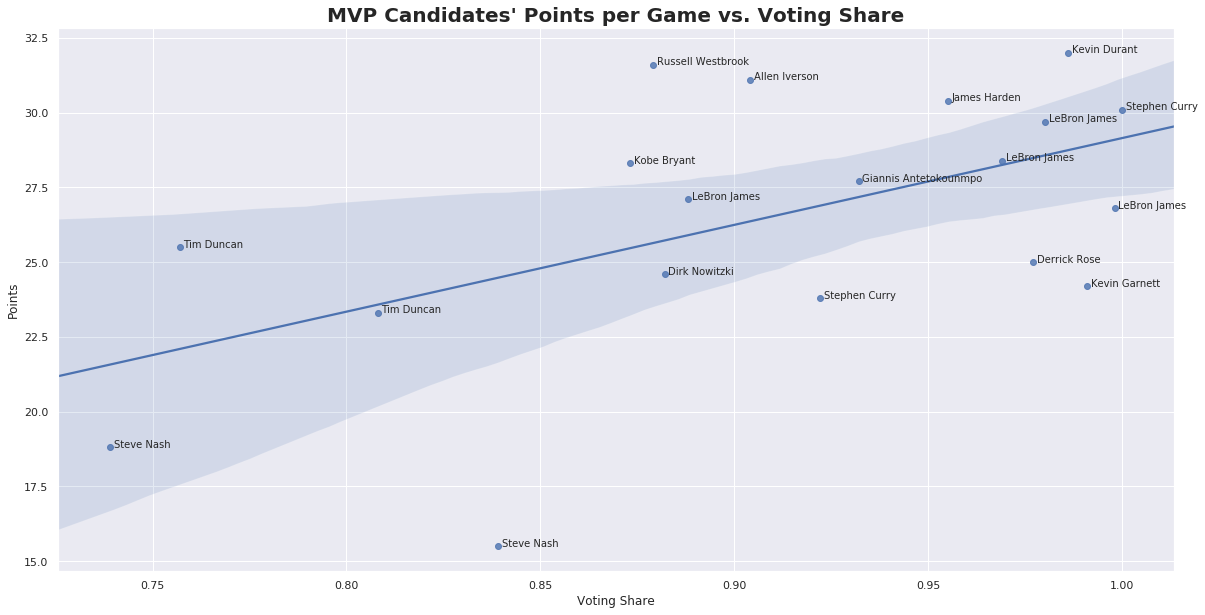

In [10]:
mvp_pg = pg[pg['Ranking'] == 1]
mvp_tm = tm[tm['Ranking'] == 1]
mvp_ctb = ctb[ctb['Ranking'] == 1]

pts = mvp_pg.loc[:, ['Name', 'VotingShare', 'PTS']]

plt.figure(figsize=(20,10))
p = sns.regplot(x='VotingShare',y='PTS',data=pts)
plt.title('MVP Candidates\' Points per Game vs. Voting Share', fontweight="bold", fontsize=20)
plt.xlabel('Voting Share')
plt.ylabel('Points')
for index, row in pts.iterrows():
    plt.annotate("".join(pts['Name'][index]), xy = (pts['VotingShare'][index] + 0.001, pts['PTS'][index]))
plt.show()

As shown above, the graph depicts the relationship between MVP candidates points per game and voting share. It appears that the graph shows a positive relationship between the two as well as a general tendency where players who score more points tend to have a higher voting share. When comparing the players to the general trend we noticed that there are two consistent outliers of the group, one being Steve Nash, and the other being Tim Duncan.
Overall, the average points scored was 26.521 points.
The highest points scored by an individual player was Kevin Durant with 32 points.
The lowest points scored by an individual player was Steve Nash with 15.5 points.

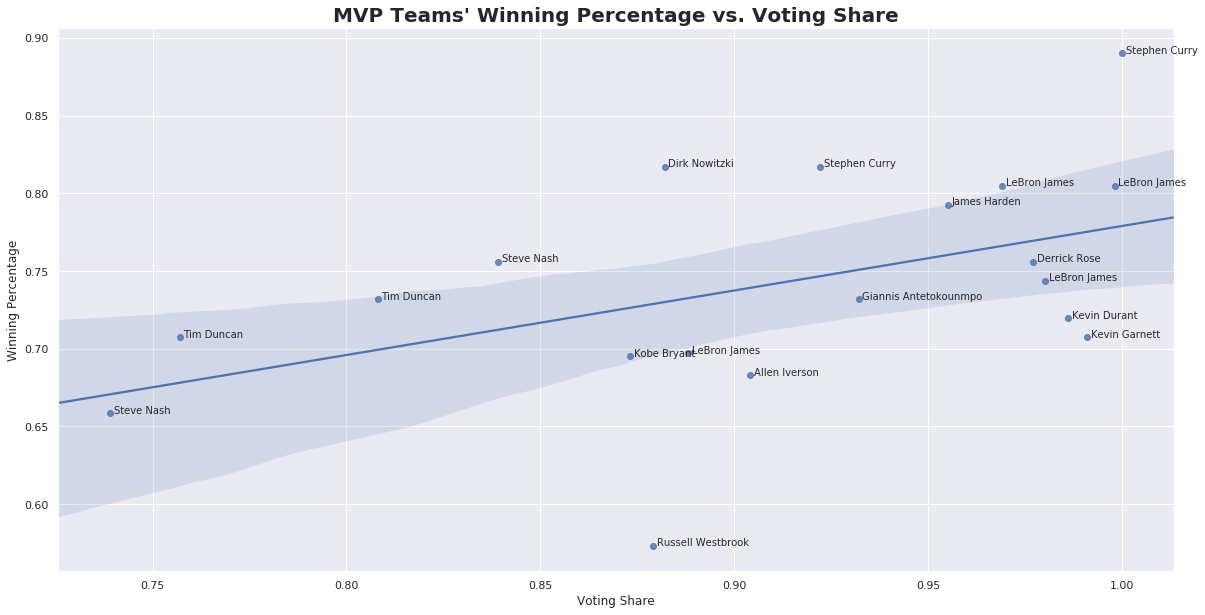

In [11]:
wins = mvp_tm.loc[:, ['Name', 'VotingShare', 'Win_Pct']]

plt.figure(figsize=(20,10))
p = sns.regplot(x='VotingShare',y='Win_Pct',data=wins)
plt.title('MVP Teams\' Winning Percentage vs. Voting Share', fontweight="bold", fontsize=20)
plt.xlabel('Voting Share')
plt.ylabel('Winning Percentage')
for index, row in pts.iterrows():
    plt.annotate("".join(wins['Name'][index]), xy = (wins['VotingShare'][index] + 0.001, wins['Win_Pct'][index]))
plt.show()

In the graph above, we show the relationship between voting share and the winning percentage of players. It appears that there is also a positive relationship between the voting share and the winning percentage of players. The graph depicts players who have high winning percentage also tend to have a high voting share.
There are some notable outliers in the graph, one being Russell Westbrook who has a winning percentage of 57.3171%. The other notable outlier is Stephen Curry with a winning percentage of 89.0244%. 
Overall, the average winning percentage among all players was 74.1432%.

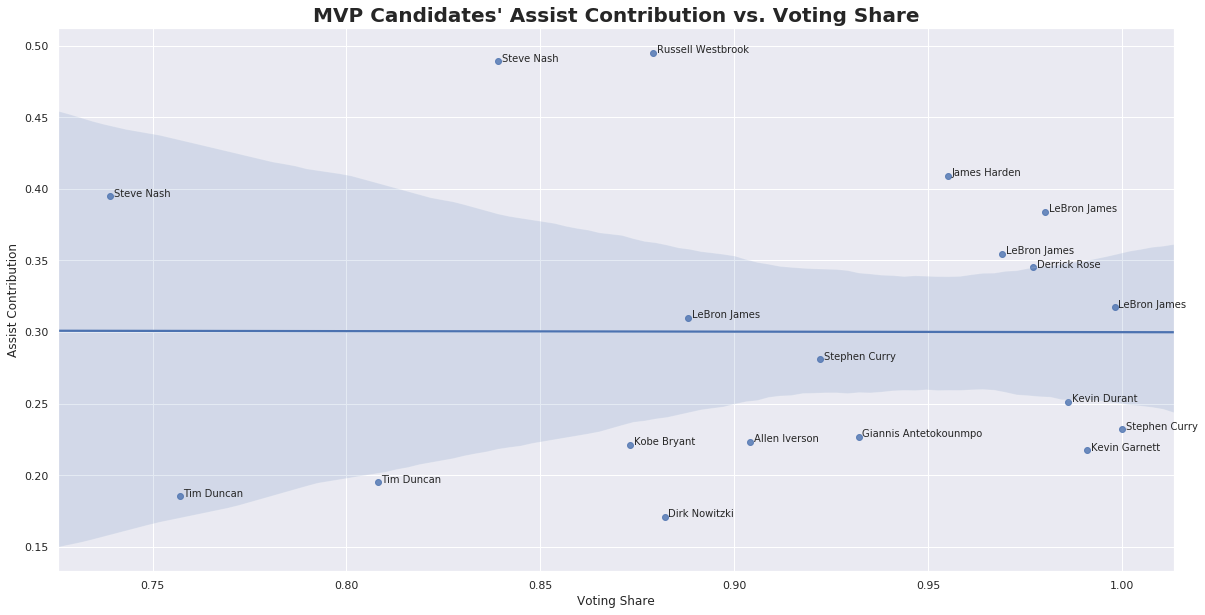

In [12]:
ast = mvp_ctb.loc[:, ['Name', 'VotingShare', 'AST_CTB']]

plt.figure(figsize=(20,10))
p = sns.regplot(x='VotingShare',y='AST_CTB',data=ast)
plt.title('MVP Candidates\' Assist Contribution vs. Voting Share', fontweight="bold", fontsize=20)
plt.xlabel('Voting Share')
plt.ylabel('Assist Contribution')
for index, row in pts.iterrows():
    plt.annotate("".join(ast['Name'][index]), xy = (ast['VotingShare'][index] + 0.001, ast['AST_CTB'][index]))
plt.show()

In this graph above, we show the relationship between MVP candidates' assist contribution and their voting share. 
We calculated this by first adding up all the individual assists by that player and dividing that by the total amount of assists by their team. This generally shows that these players tend to be large contributors to their team. There are some notable outliers in the graph, one being Russel Westbrook, with 49.5238%, and the other one being Steve Nash, with 48.9362%

Overall, the average percentage of assist contribution by and MVP candidate was 30.0195%.
The highest percentage of an assist contribution by an individual player was Russell Westbrook with 49.5238%.
The lowest percentage of an assist contribution by an individual player was Dirk Nowitzki with 17.0854%.

In [13]:
mvp_pg

,Season,Tm,Pos,G,MP,PTS,ORB,DRB,TRB,AST,...,BLK,TOV,FG%,3P%,eFG%,FT%,Name,VotingShare,Ranking,Candidate
0,2001,PHI,SG,71.0,42.0,31.1,0.7,3.1,3.8,4.6,...,0.3,3.3,0.420,0.000,0.447,0.814,Allen Iverson,0.904,1,"Allen Iverson, 2001"
5,2002,SAS,PF,82.0,40.6,25.5,3.3,9.4,12.7,3.7,...,2.5,3.2,0.508,0.100,0.508,0.799,Tim Duncan,0.757,1,"Tim Duncan, 2002"
10,2003,SAS,PF,81.0,39.3,23.3,3.2,9.7,12.9,3.9,...,2.9,3.1,0.513,0.273,0.515,0.710,Tim Duncan,0.808,1,"Tim Duncan, 2003"
15,2004,MIN,PF,82.0,39.4,24.2,3.0,10.9,13.9,5.0,...,2.2,2.6,0.499,0.000,0.502,0.791,Kevin Garnett,0.991,1,"Kevin Garnett, 2004"
20,2005,PHO,PG,75.0,34.3,15.5,0.8,2.6,3.3,11.5,...,0.1,3.3,0.502,0.000,0.557,0.887,Steve Nash,0.839,1,"Steve Nash, 2005"
25,2006,PHO,PG,79.0,35.4,18.8,0.6,3.6,4.2,10.5,...,0.2,3.5,0.512,0.000,0.583,0.921,Steve Nash,0.739,1,"Steve Nash, 2006"
30,2007,DAL,PF,78.0,36.2,24.6,1.6,7.3,8.9,3.4,...,0.8,2.1,0.502,0.416,0.529,0.904,Dirk Nowitzki,0.882,1,"Dirk Nowitzki, 2007"
35,2008,LAL,SG,82.0,38.9,28.3,1.1,5.2,6.3,5.4,...,0.5,3.1,0.459,0.361,0.503,0.840,Kobe Bryant,0.873,1,"Kobe Bryant, 2008"
40,2009,CLE,SF,81.0,37.7,28.4,1.3,6.3,7.6,7.2,...,1.1,3.0,0.489,0.000,0.530,0.780,LeBron James,0.969,1,"LeBron James, 2009"
45,2010,CLE,SF,76.0,39.0,29.7,0.9,6.4,7.3,8.6,...,1.0,3.4,0.503,0.000,0.545,0.767,LeBron James,0.980,1,"LeBron James, 2010"


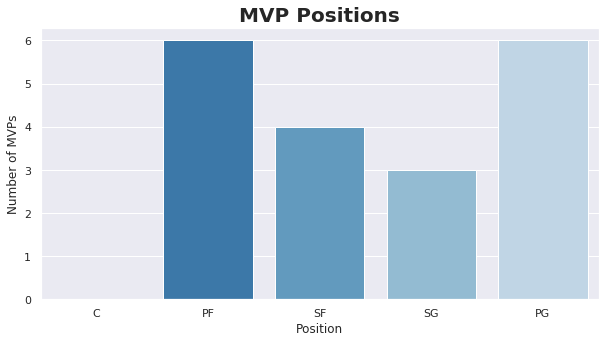

In [14]:
pos = mvp_pg['Pos']
pos_map = {'C': 0, 'PF': 0, 'SF': 0, 'SG': 0, 'PG': 0}
for p in list(pos):
    pos_map[p] += 1
pos = pd.DataFrame([pos_map]).melt()
plt.figure(figsize=(10,5))
p = sns.barplot(x='variable',y='value',data=pos, palette=sns.color_palette('Blues_r'))
plt.title('MVP Positions', fontweight="bold", fontsize=20)
plt.xlabel('Position')
plt.ylabel('Number of MVPs')
plt.show()

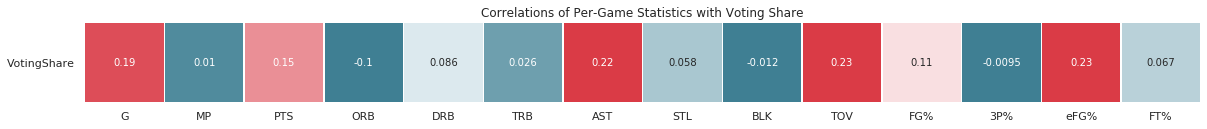

In [15]:
cmap = sns.diverging_palette(220,10, as_cmap=True)
temp = pg.drop(columns=['Season', 'Tm', 'Candidate', 'Ranking', 'Name', 'Pos'])
corr = temp.corr()[['G','MP','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%','eFG%','FT%']]
corr = corr.take([len(temp.corr().columns)-1])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.2)
plt.yticks(rotation=0)
plt.title('Correlations of Per-Game Statistics with Voting Share')
plt.show()

The heat map above was useful when determining the best candidate for an MVP by showing the correlation between per-game statistics and voting share. Taking a closer look at the graph shows a more significant relationship between voting share to games played (G), MVP candidates' assist contribution (AST), turnovers (TOV), and effective field goal percentage (eFG). One thing to note is that having a high turnover percentage is not desirable but is still indicative of a good player.

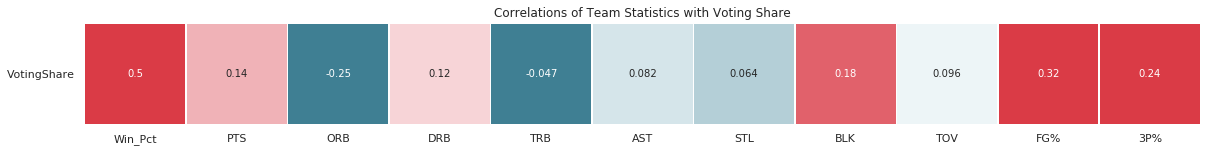

In [16]:
temp = tm.drop(columns=['Season', 'Tm', 'Candidate', 'Ranking', 'Name'])
corr = temp.corr()[['Win_Pct','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%']]
corr = corr.take([len(temp.corr().columns)-1])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.2)
plt.yticks(rotation=0)
plt.title('Correlations of Team Statistics with Voting Share')
plt.show()

In the heat map above, we depicted the correlations between team statistics and voting share. This map was useful because it allowed us to select our features for the final model. Some of the more significant correlations between team statistics and voting share was the winning percentage (Win_Pct), the blocks (BLK), field goal percentage (FG%), and three-point percentage (3P%). Overall, winning percentage was our high correlation between the two.

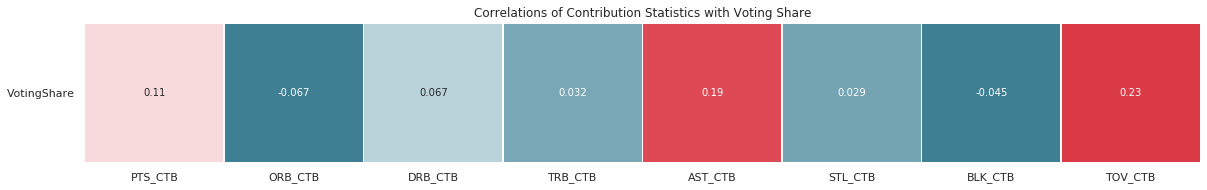

In [17]:
temp = ctb.drop(columns=['Season', 'Tm', 'Candidate', 'Ranking', 'Name'])
corr = temp.corr()[['PTS_CTB','ORB_CTB','DRB_CTB','TRB_CTB','AST_CTB','STL_CTB','BLK_CTB','TOV_CTB']]
corr = corr.take([len(temp.corr().columns)-1])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.2)
plt.yticks(rotation=0)
plt.title('Correlations of Contribution Statistics with Voting Share')
plt.show()

This heat map depicts the correlation between contribution statistics and voting share. This map was also useful when selecting features for our final model. Some more significant correlations between the two were assist contribution (AST_CTB), and turn over contribution (TOV_CTB). Overall, the turn over contribution was our high correlation between the two.

In [18]:
def select(pg, tm, ctb, lists):
    pg_select = pg.copy(deep=True)[lists[0]]
    tm_select = tm.copy(deep=True)[lists[1]]
    ctb_select = ctb.copy(deep=True)[lists[2]]
    return pd.concat([pg_select, tm_select, ctb_select], axis=1)

def rsd_plot(x, rsd):
    plt.figure(figsize=(20,10))
    sns.violinplot(x=x,y=rsd)
    plt.title('Residuals vs. MVP Ranking', fontweight="bold", fontsize=20)
    plt.xlabel('MVP Ranking')
    plt.ylabel('Residual')
    plt.show()

def predict(name, team_name, year, reg, lists):
    pergame = pd.DataFrame()
    team = pd.DataFrame()
    (pergame, team) = collect([name], [team_name], year, pergame, team)
    
    ctb = pd.DataFrame()
    ctb['Season'] = pergame['Season']
    ctb['Tm'] = pergame['Tm']
    for col in ['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV']:
        ctb[str(col+'_CTB')] = pergame[col]/tm[col]
    ctb['Name'] = pergame['Name']
    ctb['Candidate'] = pergame['Candidate']
    select_test = select(pergame, team, ctb, lists)
    return reg.predict(select_test)[0]

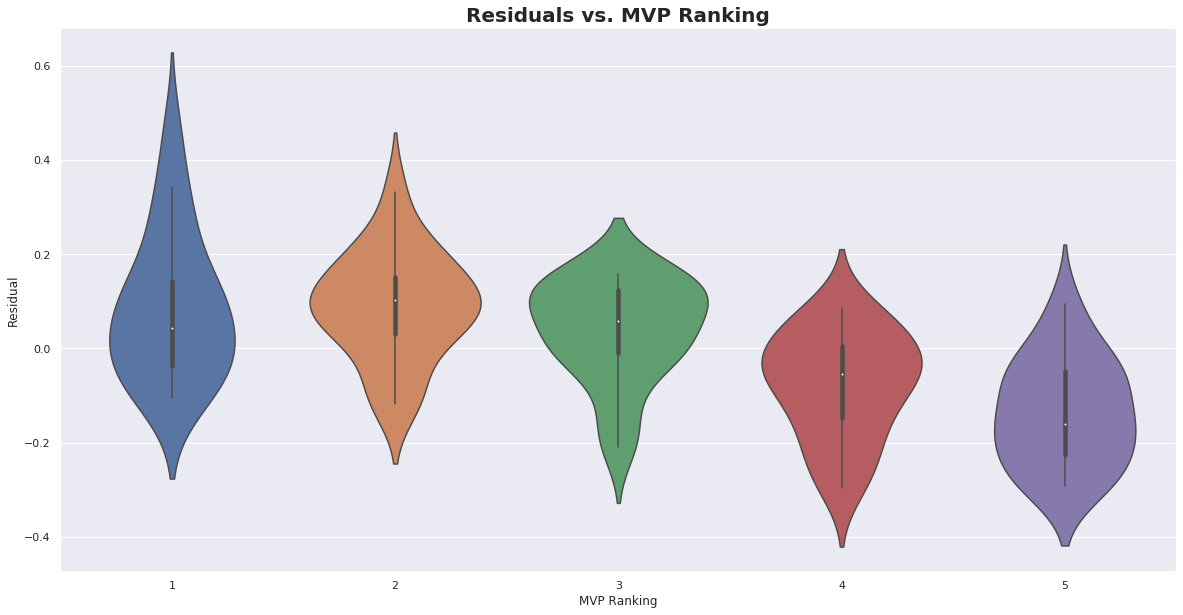

In [19]:
pg_list = ['Ranking', 'G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'eFG%', 
           'FT%']
tm_list = ['Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%']
ctb_list = ['PTS_CTB', 'ORB_CTB', 'DRB_CTB', 'TRB_CTB', 'AST_CTB', 'STL_CTB', 'BLK_CTB', 'TOV_CTB']
X = select(pg, tm, ctb, [pg_list, tm_list, ctb_list])
y = pg['VotingShare']
reg1 = linear_model.LinearRegression()
reg1.fit(X.drop(columns=['Ranking']), y)
rsd_plot(X['Ranking'], y - reg1.predict(X.drop(columns=['Ranking'])))

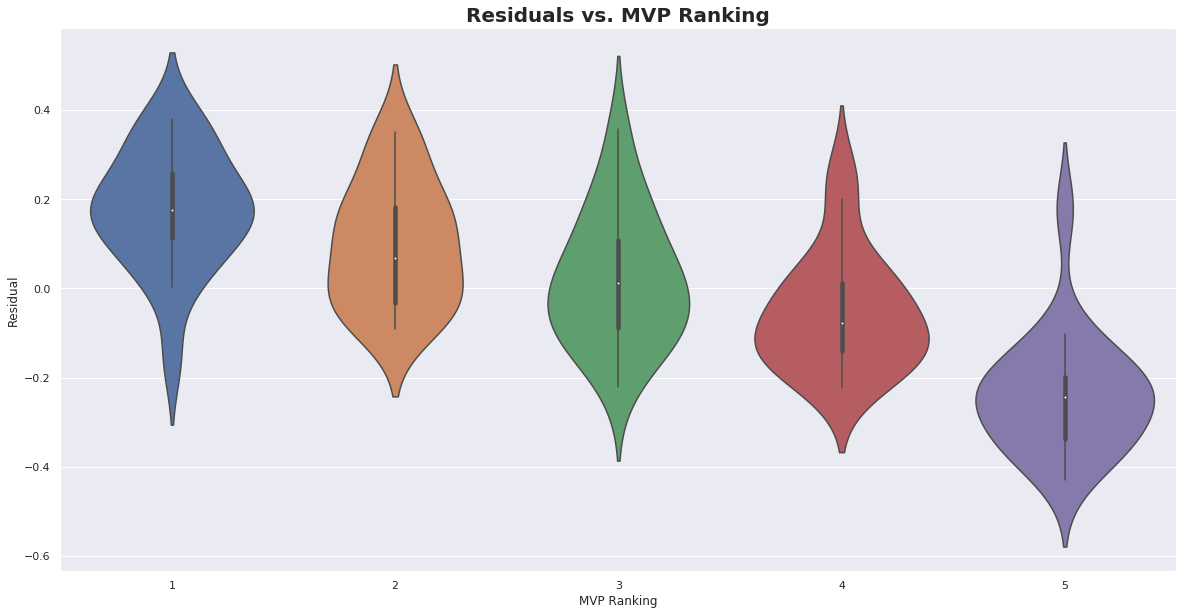

In [20]:
pg_list = ['Ranking', 'G', 'PTS', 'AST', 'TOV', 'eFG%']
tm_list = ['Win_Pct']
ctb_list = ['PTS_CTB', 'AST_CTB', 'TOV_CTB']
X = select(pg, tm, ctb, [pg_list, tm_list, ctb_list])
y = pg['VotingShare']
reg2 = linear_model.LinearRegression()
reg2.fit(X.drop(columns=['Ranking']), y)
rsd_plot(X['Ranking'], y - reg2.predict(X.drop(columns=['Ranking'])))

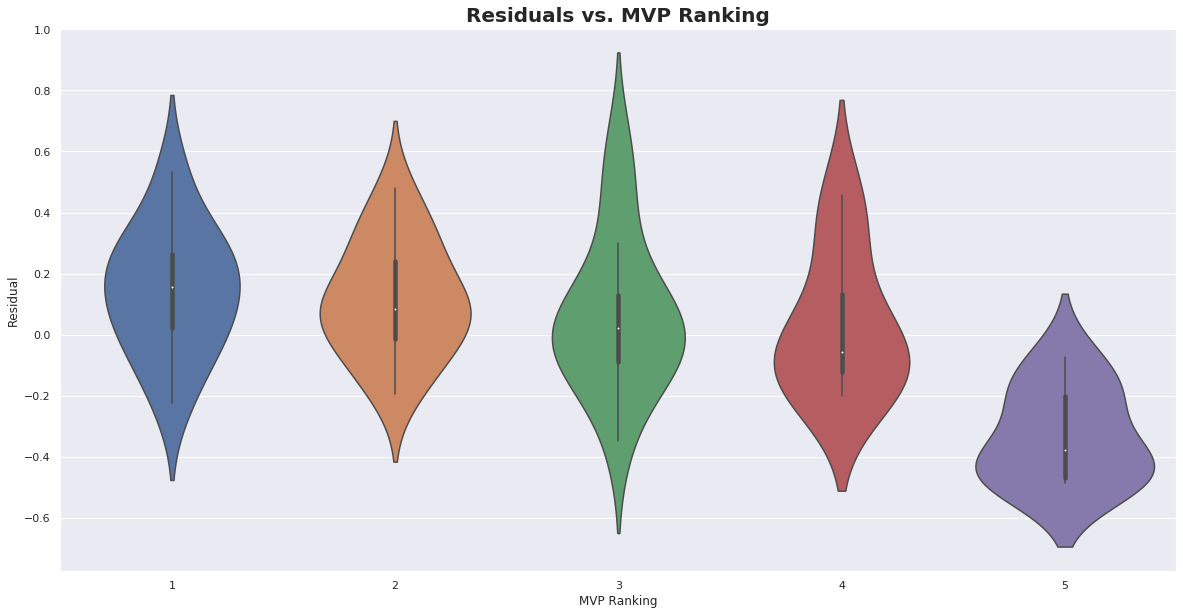

In [21]:
X = select(pg, tm, ctb, [pg_list, tm_list, ctb_list])
y = pg['VotingShare']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6)
X_train = X_train.drop(columns=['Ranking'])
reg3 = linear_model.LinearRegression()
reg3.fit(X_train, y_train)
rsd_plot(X_test['Ranking'], y_test - reg3.predict(X_test.drop(columns=['Ranking'])))

In [22]:
tables = pd.read_html('https://basketball.realgm.com/nba/players/2019')
table = tables[12].copy(deep=True)[tables[12]['GP'] >= 41]
j = 0
for i, x in table.iterrows():
    if len(x['Teams']) > 3:
        table.drop(table.index[j], inplace=True)
        j -= 1
    j += 1
players = table[['Player', 'Teams']].sample(n=5)
pg_list = ['G', 'PTS', 'AST', 'TOV', 'eFG%']
tm_list = ['Win_Pct']
ctb_list = ['PTS_CTB', 'AST_CTB', 'TOV_CTB']
lists = [pg_list, tm_list, ctb_list]
predictions = pd.DataFrame()
for (name, team) in zip(players['Player'], players['Teams']):
    print(name)
    prediction = predict(name, team, 2019, reg3, lists)
    predictions = predictions.append(pd.DataFrame([[name, prediction]], columns=['Player', 
                        'Predicted VotingShare']), sort=False).reset_index()[['Player', 'Predicted VotingShare']]
predictions

Georges Niang
Jamal Murray
Maybyner Nene


HTTPError: HTTP Error 404: Not Found